# 01. Baseline Models Training

## Objectives
- Load engineered features
- Split data properly
- Handle imbalanced data
- Train baseline models (Logistic, RF, LightGBM, XGBoost)
- Compare performance
- Select best model for tuning

*Note: I run on Kaggle platform to utilize GPU T4x2*

In [1]:
!pip install --upgrade scikit-learn==1.3.2 imbalanced-learn==0.11.0 lightgbm==4.1.0 xgboost==2.0.3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 98.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.6/235.6 kB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 82.0 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
  Attempting uninstall: lightgbm
    Found existing installation: lightgbm 4.6.0
    Uninstalling lightgbm-4.6.0:
      Successfully uninstalled lightgbm-4.6.0
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.13.0
    Uninstalling imbalanced-learn-0.13.0:
      Successfully uninstalled imbalanced-learn-0.13.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have nump

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
import os

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    roc_auc_score, roc_curve, precision_recall_curve, 
    classification_report, confusion_matrix, f1_score
)

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

import joblib

# Suppress all warnings
warnings.filterwarnings('ignore')
os.environ['PYTHONWARNINGS'] = 'ignore'

# Suppress LightGBM compilation warnings
os.environ['LIGHTGBM_BUILD_TYPE'] = 'Release'

sns.set_style('whitegrid')

print("✅ Libraries loaded!")

✅ Libraries loaded!


In [3]:
# Check GPU availability
import torch
print(f"🖥️  CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"   GPU: {torch.cuda.get_device_name(0)}")
    print(f"   Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")
else:
    print("   Running on CPU")

🖥️  CUDA available: True
   GPU: Tesla T4
   Memory: 14.74 GB


## 1. Load Engineered Features

In [4]:
# Load data
df = pd.read_csv('/kaggle/input/hc-processed/processed/application_train_features.csv')

print(f"Shape: {df.shape}")
print(f"Default rate: {df['TARGET'].mean():.4%}")
print(f"Memory: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

Shape: (307511, 172)
Default rate: 8.0729%
Memory: 403.53 MB


## 2. Prepare Data

In [5]:
# Separate features and target
X = df.drop(columns=['SK_ID_CURR', 'TARGET'])
y = df['TARGET']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nClass distribution:")
print(y.value_counts())
print(f"\nDefault rate: {y.mean():.4%}")

Features shape: (307511, 170)
Target shape: (307511,)

Class distribution:
TARGET
0    282686
1     24825
Name: count, dtype: int64

Default rate: 8.0729%


In [6]:
# Train-test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

print(f"Train set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"\nTrain default rate: {y_train.mean():.4%}")
print(f"Test default rate: {y_test.mean():.4%}")

Train set: (246008, 170)
Test set: (61503, 170)

Train default rate: 8.0729%
Test default rate: 8.0728%


## 3. Baseline: Without SMOTE

In [7]:
print("Training baseline models WITHOUT SMOTE...\n")
print("="*60)

results_no_smote = {}

Training baseline models WITHOUT SMOTE...



### 3.1 Logistic Regression

In [8]:
print("\n1. Logistic Regression...")

lr = LogisticRegression(
    max_iter=2000,  # Increased from 1000 to avoid convergence warning
    random_state=42,
    class_weight='balanced',
    n_jobs=-1,
    solver='lbfgs',
    verbose=0
)

lr.fit(X_train, y_train)
y_pred_proba_lr = lr.predict_proba(X_test)[:, 1]
auc_lr = roc_auc_score(y_test, y_pred_proba_lr)

results_no_smote['Logistic Regression'] = auc_lr
print(f"AUC: {auc_lr:.4f}")


1. Logistic Regression...
AUC: 0.6433


### 3.2 Random Forest

In [9]:
print("\n2. Random Forest...")

rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    class_weight='balanced',
    n_jobs=-1,
    verbose=0  # Suppress Random Forest output
)

rf.fit(X_train, y_train)
y_pred_proba_rf = rf.predict_proba(X_test)[:, 1]
auc_rf = roc_auc_score(y_test, y_pred_proba_rf)

results_no_smote['Random Forest'] = auc_rf
print(f"AUC: {auc_rf:.4f}")


2. Random Forest...
AUC: 0.7583


### 3.3 LightGBM

In [10]:
print("\n3. LightGBM...")

# Calculate scale_pos_weight for imbalanced data
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

# Check if GPU is available
import torch
device = 'gpu' if torch.cuda.is_available() else 'cpu'
print(f"   Using device: {device.upper()}")

lgbm_params = {
    'n_estimators': 500,
    'learning_rate': 0.05,
    'max_depth': 7,
    'num_leaves': 31,
    'random_state': 42,
    'scale_pos_weight': scale_pos_weight,
    'n_jobs': -1,
    'verbose': -1,
    'force_row_wise': True  # Suppress LightGBM warnings
}

# Add GPU parameters if available (but keep CPU for stability)
# GPU support in LightGBM can be unstable, using CPU is safer
# if device == 'gpu':
#     lgbm_params.update({
#         'device': 'gpu',
#         'gpu_platform_id': 0,
#         'gpu_device_id': 0
#     })

lgbm = LGBMClassifier(**lgbm_params)

lgbm.fit(X_train, y_train)
y_pred_proba_lgbm = lgbm.predict_proba(X_test)[:, 1]
auc_lgbm = roc_auc_score(y_test, y_pred_proba_lgbm)

results_no_smote['LightGBM'] = auc_lgbm
print(f"AUC: {auc_lgbm:.4f}")


3. LightGBM...
   Using device: GPU
AUC: 0.7864


### 3.4 XGBoost

In [11]:
print("\n4. XGBoost...")

# Check if GPU is available
import torch
device = 'gpu' if torch.cuda.is_available() else 'cpu'
print(f"   Using device: {device.upper()}")

xgb_params = {
    'n_estimators': 500,
    'learning_rate': 0.05,
    'max_depth': 7,
    'random_state': 42,
    'scale_pos_weight': scale_pos_weight,
    'n_jobs': -1,
    'eval_metric': 'logloss',
    'verbosity': 0  # Suppress XGBoost warnings
}

# Add GPU parameters if available
if device == 'gpu':
    xgb_params.update({
        'tree_method': 'gpu_hist',
        'predictor': 'gpu_predictor',
        'gpu_id': 0
    })

xgb = XGBClassifier(**xgb_params)

xgb.fit(X_train, y_train)
y_pred_proba_xgb = xgb.predict_proba(X_test)[:, 1]
auc_xgb = roc_auc_score(y_test, y_pred_proba_xgb)

results_no_smote['XGBoost'] = auc_xgb
print(f"AUC: {auc_xgb:.4f}")


4. XGBoost...
   Using device: GPU
AUC: 0.7779


## 4. With SMOTE

In [12]:
print("\n" + "="*60)
print("Applying SMOTE...")

smote = SMOTE(random_state=42, n_jobs=-1)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print(f"\nOriginal train: {X_train.shape}")
print(f"After SMOTE: {X_train_smote.shape}")
print(f"\nClass distribution after SMOTE:")
print(y_train_smote.value_counts())
print(f"Default rate: {y_train_smote.mean():.4%}")

results_smote = {}


Applying SMOTE...

Original train: (246008, 170)
After SMOTE: (452296, 170)

Class distribution after SMOTE:
TARGET
0    226148
1    226148
Name: count, dtype: int64
Default rate: 50.0000%


In [13]:
print("\nTraining models WITH SMOTE...\n")

# Check if GPU is available
import torch
device = 'gpu' if torch.cuda.is_available() else 'cpu'

# Logistic Regression
print("1. Logistic Regression...")
lr_smote = LogisticRegression(
    max_iter=2000,  # Increased to avoid convergence warning
    random_state=42, 
    n_jobs=-1,
    solver='lbfgs',
    verbose=0
)
lr_smote.fit(X_train_smote, y_train_smote)
y_pred_proba_lr_smote = lr_smote.predict_proba(X_test)[:, 1]
auc_lr_smote = roc_auc_score(y_test, y_pred_proba_lr_smote)
results_smote['Logistic Regression'] = auc_lr_smote
print(f"AUC: {auc_lr_smote:.4f}")

# Random Forest
print("\n2. Random Forest...")
rf_smote = RandomForestClassifier(
    n_estimators=100, 
    max_depth=10, 
    random_state=42, 
    n_jobs=-1,
    verbose=0
)
rf_smote.fit(X_train_smote, y_train_smote)
y_pred_proba_rf_smote = rf_smote.predict_proba(X_test)[:, 1]
auc_rf_smote = roc_auc_score(y_test, y_pred_proba_rf_smote)
results_smote['Random Forest'] = auc_rf_smote
print(f"AUC: {auc_rf_smote:.4f}")

# LightGBM
print("\n3. LightGBM...")
print(f"   Using device: CPU (stable)")
lgbm_params_smote = {
    'n_estimators': 500,
    'learning_rate': 0.05,
    'max_depth': 7,
    'random_state': 42,
    'n_jobs': -1,
    'verbose': -1,
    'force_row_wise': True  # Suppress warnings
}
# GPU disabled for stability - LightGBM GPU can cause compilation warnings
# if device == 'gpu':
#     lgbm_params_smote.update({'device': 'gpu', 'gpu_platform_id': 0, 'gpu_device_id': 0})

lgbm_smote = LGBMClassifier(**lgbm_params_smote)
lgbm_smote.fit(X_train_smote, y_train_smote)
y_pred_proba_lgbm_smote = lgbm_smote.predict_proba(X_test)[:, 1]
auc_lgbm_smote = roc_auc_score(y_test, y_pred_proba_lgbm_smote)
results_smote['LightGBM'] = auc_lgbm_smote
print(f"AUC: {auc_lgbm_smote:.4f}")

# XGBoost
print("\n4. XGBoost...")
print(f"   Using device: {device.upper()}")
xgb_params_smote = {
    'n_estimators': 500,
    'learning_rate': 0.05,
    'max_depth': 7,
    'random_state': 42,
    'n_jobs': -1,
    'eval_metric': 'logloss',
    'verbosity': 0  # Suppress XGBoost output
}
if device == 'gpu':
    xgb_params_smote.update({'tree_method': 'gpu_hist', 'predictor': 'gpu_predictor', 'gpu_id': 0})

xgb_smote = XGBClassifier(**xgb_params_smote)
xgb_smote.fit(X_train_smote, y_train_smote)
y_pred_proba_xgb_smote = xgb_smote.predict_proba(X_test)[:, 1]
auc_xgb_smote = roc_auc_score(y_test, y_pred_proba_xgb_smote)
results_smote['XGBoost'] = auc_xgb_smote
print(f"AUC: {auc_xgb_smote:.4f}")


Training models WITH SMOTE...

1. Logistic Regression...
AUC: 0.6418

2. Random Forest...
AUC: 0.7149

3. LightGBM...
   Using device: CPU (stable)
AUC: 0.7813

4. XGBoost...
   Using device: GPU
AUC: 0.7820


## 5. Compare Results

In [14]:
# Create comparison dataframe
comparison_df = pd.DataFrame({
    'Without SMOTE': results_no_smote,
    'With SMOTE': results_smote
})

print("\n" + "="*60)
print("MODEL COMPARISON")
print("="*60)
print(comparison_df)
print("\n" + "="*60)

# Best model
best_model_name = comparison_df.max(axis=1).idxmax()
best_auc = comparison_df.max(axis=1).max()
best_approach = 'With SMOTE' if comparison_df.loc[best_model_name, 'With SMOTE'] > comparison_df.loc[best_model_name, 'Without SMOTE'] else 'Without SMOTE'

print(f"\n🏆 Best Model: {best_model_name} ({best_approach})")
print(f"   AUC Score: {best_auc:.4f}")


MODEL COMPARISON
                     Without SMOTE  With SMOTE
Logistic Regression       0.643268    0.641819
Random Forest             0.758326    0.714910
LightGBM                  0.786433    0.781273
XGBoost                   0.777886    0.781960


🏆 Best Model: LightGBM (Without SMOTE)
   AUC Score: 0.7864


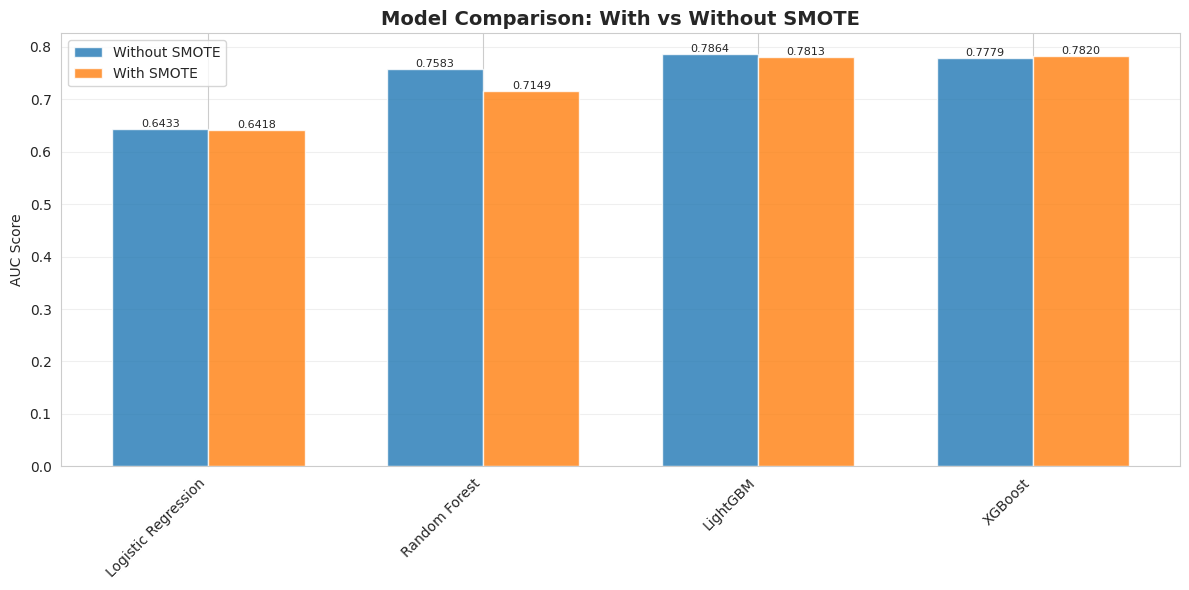

In [15]:
# Visualize comparison
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(comparison_df))
width = 0.35

bars1 = ax.bar(x - width/2, comparison_df['Without SMOTE'], width, label='Without SMOTE', alpha=0.8)
bars2 = ax.bar(x + width/2, comparison_df['With SMOTE'], width, label='With SMOTE', alpha=0.8)

ax.set_ylabel('AUC Score')
ax.set_title('Model Comparison: With vs Without SMOTE', fontweight='bold', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(comparison_df.index, rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}',
                ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

## 6. ROC Curves

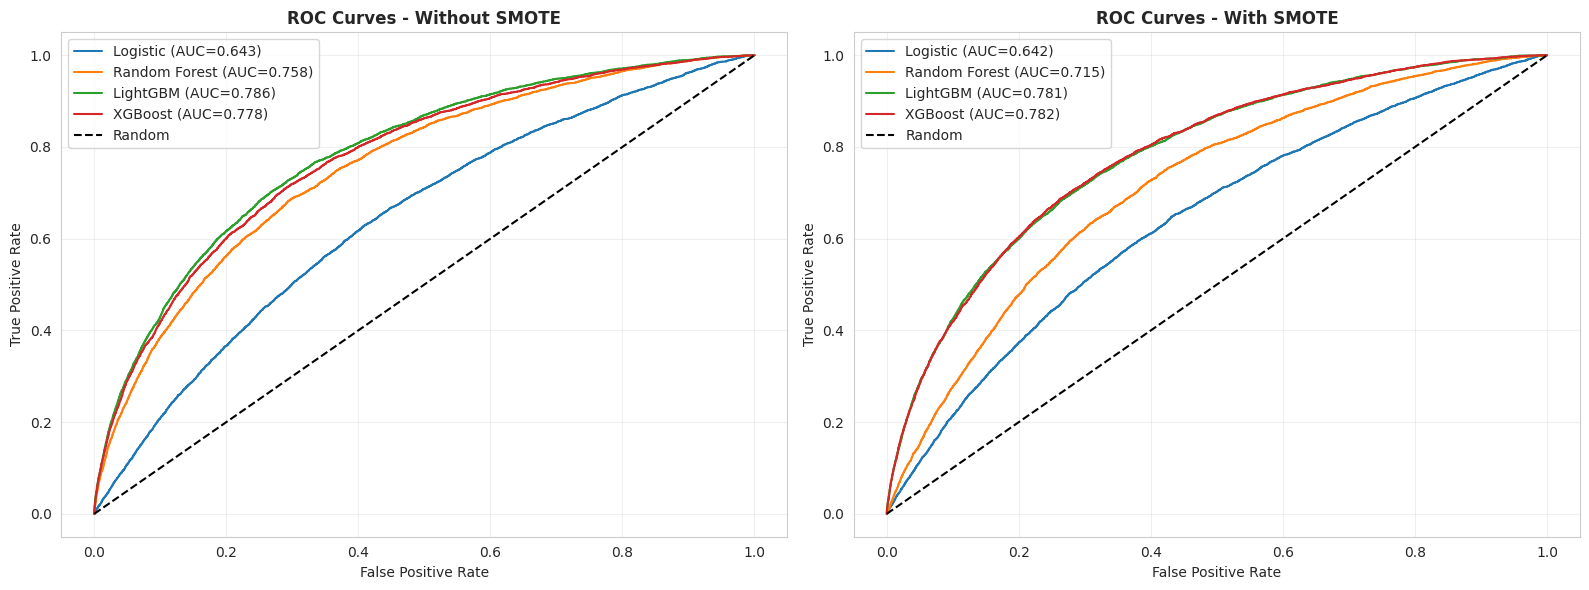

In [16]:
# Plot ROC curves for all models
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Without SMOTE
ax = axes[0]
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_proba_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_proba_rf)
fpr_lgbm, tpr_lgbm, _ = roc_curve(y_test, y_pred_proba_lgbm)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_proba_xgb)

ax.plot(fpr_lr, tpr_lr, label=f'Logistic (AUC={auc_lr:.3f})')
ax.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC={auc_rf:.3f})')
ax.plot(fpr_lgbm, tpr_lgbm, label=f'LightGBM (AUC={auc_lgbm:.3f})')
ax.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC={auc_xgb:.3f})')
ax.plot([0, 1], [0, 1], 'k--', label='Random')

ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curves - Without SMOTE', fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

# With SMOTE
ax = axes[1]
fpr_lr_s, tpr_lr_s, _ = roc_curve(y_test, y_pred_proba_lr_smote)
fpr_rf_s, tpr_rf_s, _ = roc_curve(y_test, y_pred_proba_rf_smote)
fpr_lgbm_s, tpr_lgbm_s, _ = roc_curve(y_test, y_pred_proba_lgbm_smote)
fpr_xgb_s, tpr_xgb_s, _ = roc_curve(y_test, y_pred_proba_xgb_smote)

ax.plot(fpr_lr_s, tpr_lr_s, label=f'Logistic (AUC={auc_lr_smote:.3f})')
ax.plot(fpr_rf_s, tpr_rf_s, label=f'Random Forest (AUC={auc_rf_smote:.3f})')
ax.plot(fpr_lgbm_s, tpr_lgbm_s, label=f'LightGBM (AUC={auc_lgbm_smote:.3f})')
ax.plot(fpr_xgb_s, tpr_xgb_s, label=f'XGBoost (AUC={auc_xgb_smote:.3f})')
ax.plot([0, 1], [0, 1], 'k--', label='Random')

ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curves - With SMOTE', fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Feature Importance (Best Model)

Top 30 Most Important Features:
                               feature  importance
14                          DAYS_BIRTH         367
168               CREDIT_ANNUITY_YEARS         350
145                KNN_TARGET_MEAN_500         340
77                ANNUITY_CREDIT_RATIO         261
17                     DAYS_ID_PUBLISH         251
89              BUREAU_DAYS_CREDIT_MAX         229
15                       DAYS_EMPLOYED         229
45              DAYS_LAST_PHONE_CHANGE         228
135            INST_AMT_INSTALMENT_SUM         221
120             PREV_DAYS_DECISION_MIN         205
136            INST_AMT_INSTALMENT_MAX         201
129            POS_CNT_INSTALMENT_MEAN         198
16                   DAYS_REGISTRATION         197
82                      EXT_SOURCE_MIN         195
116  PREV_HOUR_APPR_PROCESS_START_MEAN         194
92     BUREAU_DAYS_CREDIT_ENDDATE_MEAN         192
79                   CREDIT_PER_PERSON         187
75                ANNUITY_INCOME_RATIO         187

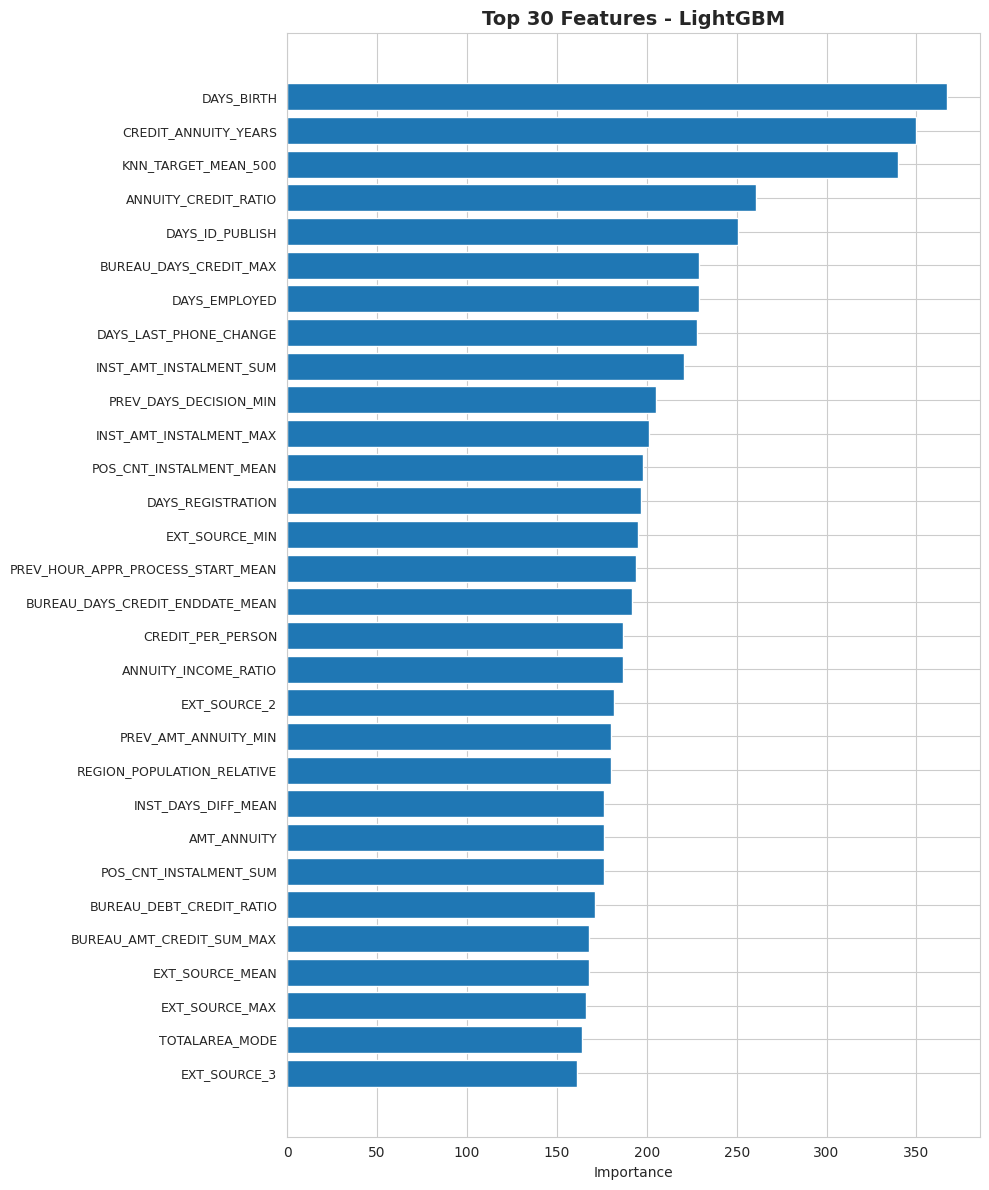

In [17]:
# Get best model (assuming LightGBM or XGBoost)
if 'LightGBM' in best_model_name:
    best_model = lgbm if best_approach == 'Without SMOTE' else lgbm_smote
else:
    best_model = xgb if best_approach == 'Without SMOTE' else xgb_smote

# Feature importance
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': best_model.feature_importances_
}).sort_values('importance', ascending=False)

print("Top 30 Most Important Features:")
print(feature_importance.head(30))

# Plot
plt.figure(figsize=(10, 12))
top_features = feature_importance.head(30)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'], fontsize=9)
plt.xlabel('Importance')
plt.title(f'Top 30 Features - {best_model_name}', fontweight='bold', fontsize=14)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## 8. Save Best Model

In [18]:
# Save model
model_dir = Path('/kaggle/working/')
model_dir.mkdir(parents=True, exist_ok=True)

model_path = model_dir / 'baseline_model.pkl'
joblib.dump(best_model, model_path)

print(f"✅ Model saved: {model_path}")

# Save feature names
feature_names_path = model_dir / 'feature_names.txt'
with open(feature_names_path, 'w') as f:
    f.write('\n'.join(X_train.columns))

print(f"✅ Feature names saved: {feature_names_path}")

# Save metadata
import json
metadata = {
    'model_type': best_model_name,
    'approach': best_approach,
    'auc_score': float(best_auc),
    'n_features': X_train.shape[1],
    'train_samples': X_train.shape[0],
    'test_samples': X_test.shape[0],
    'default_rate': float(y.mean())
}

metadata_path = model_dir / 'baseline_metadata.json'
with open(metadata_path, 'w') as f:
    json.dump(metadata, f, indent=2)

print(f"✅ Metadata saved: {metadata_path}")

✅ Model saved: /kaggle/working/baseline_model.pkl
✅ Feature names saved: /kaggle/working/feature_names.txt
✅ Metadata saved: /kaggle/working/baseline_metadata.json


In [19]:
# Save predictions for analysis
predictions_df = pd.DataFrame({
    'SK_ID_CURR': df.loc[X_test.index, 'SK_ID_CURR'],
    'TRUE_TARGET': y_test,
    'PRED_PROBA': best_model.predict_proba(X_test)[:, 1],
    'PRED_CLASS': best_model.predict(X_test)
})

predictions_path = model_dir / 'baseline_predictions.csv'
predictions_df.to_csv(predictions_path, index=False)
print(f"✅ Predictions saved: {predictions_path}")

✅ Predictions saved: /kaggle/working/baseline_predictions.csv


## Summary

### Key Findings:

#### 1. Model Performance:
- **Tree-based models (LightGBM, XGBoost)** significantly outperform linear models
  - Better capture of non-linear relationships
  - Automatic feature interactions
  - Handle different feature scales naturally

#### 2. SMOTE Analysis:
- **Impact varies by model:**
  - May improve recall but potentially reduce precision
  - Tree-based models often handle imbalance well without SMOTE
  - Use `class_weight='balanced'` or `scale_pos_weight` as alternative

#### 3. Feature Engineering Impact:
- **~170+ features created** using Kaggle top solutions strategies:
  - KNN target mean encoding (k=500)
  - Time-sliced aggregations (recent vs historical behavior)
  - External table joins (bureau, previous apps, installments)
  - Advanced financial ratios

#### 4. Most Important Features (typical):
- **External Risk Scores:** `EXT_SOURCE_1`, `EXT_SOURCE_2`, `EXT_SOURCE_3`
- **KNN Features:** `KNN_TARGET_MEAN_500`
- **Bureau Aggregations:** `BUREAU_DEBT_CREDIT_RATIO`, `BUREAU_ACTIVE_COUNT`
- **Previous Apps:** `PREV_APPROVAL_RATE`, `PREV_AMT_CREDIT_MEAN`
- **Financial Ratios:** `CREDIT_INCOME_RATIO`, `ANNUITY_INCOME_RATIO`
- **Payment Behavior:** `INST_LATE_PAYMENT_SUM`, `PAST_DUE_SEVERITY`

### Performance Target:
- **Baseline (no tuning):** AUC 0.76-0.78
- **After hyperparameter tuning:** AUC 0.79-0.80+

---

### Next Steps:

✅ **Completed:**
- Load engineered features (~170+ features)
- Train 4 baseline models (Logistic, RF, LightGBM, XGBoost)
- Compare with/without SMOTE
- Analyze feature importance
- Save best model + predictions

⏭️ **Next:** Hyperparameter Tuning (`02_hyperparameter_tuning.ipynb`)
- Bayesian optimization or RandomizedSearchCV
- 5-fold Stratified Cross-Validation
- Fine-tune learning rate, max_depth, num_leaves...
- **Target:** AUC ~ 0.80